In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
data_dir = '/kaggle/input/classification-skin/content/drive/MyDrive/skin_classification/Classification_Processed'
train_path = os.path.join(data_dir, 'Processed_train')
val_path = os.path.join(data_dir, 'Processed_validate')
train_csv = '/kaggle/input/classification-csv/train.csv'
val_csv = '/kaggle/input/classification-csv/val.csv'

In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import albumentations as A
import cv2

class CustomImageGenerator(Sequence):
    def __init__(self, csv_path, image_dir, batch_size=32, target_size=(224, 224), shuffle=True, augment=False):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment

        # Define class names from columns (excluding 'image')
        self.class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
        
        # Convert one-hot labels to class index
        self.df['encoded_label'] = self.df[self.class_names].values.argmax(axis=1)
        self.num_classes = len(self.class_names)

        # Store filenames and labels
        self.image_filenames = self.df['image'].values
        self.labels = self.df['encoded_label'].values

        # Define augmentation if enabled
        if self.augment:
            self.aug = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                A.GaussianBlur(p=0.2),
            ])
        else:
            self.aug = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        for img_name in batch_images:
            img_path = os.path.join(self.image_dir, img_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, self.target_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.aug:
                image = self.aug(image=image)['image']

            image = image / 255.0  # Normalize to [0, 1]
            images.append(image)

        X = np.array(images)
        y = to_categorical(batch_labels, num_classes=self.num_classes)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            idxs = np.arange(len(self.image_filenames))
            np.random.shuffle(idxs)
            self.image_filenames = self.image_filenames[idxs]
            self.labels = self.labels[idxs]


2025-08-14 03:30:57.901659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755142258.206442      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755142258.303295      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from albumentations.pytorch import ToTensorV2
train_gen = CustomImageGenerator(
    csv_path=train_csv,
    image_dir=train_path,
    batch_size=32,
    target_size=(224, 224),
    shuffle=True,
    augment=True  # ✅ Enable augmentation
)

val_gen = CustomImageGenerator(
    csv_path=val_csv,
    image_dir=val_path,
    batch_size=32,
    target_size=(224, 224),
    shuffle=False,
    augment=False  # ❌ No augmentation for validation
)




/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Load your CSV (same as used for training)
df = pd.read_csv(train_csv)

# List of class names
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# Convert one-hot labels to class indices
y_int = df[class_names].values.argmax(axis=1)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=y_int
)

# Convert to dictionary format (required by Keras)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: 0.7018286890436986, 1: 0.2460724991673143, 2: 0.9561583261432269, 3: 3.6755804311774463, 4: 1.20783378746594, 5: 12.961257309941521, 6: 12.521892655367232, 7: 4.797348484848484}


In [4]:
checkpoint_path = '/kaggle/working/second_phase'
last_epoch_file = os.path.join(checkpoint_path, 'last_epoch.txt')
initial_model_path = '/kaggle/input/epoch18/tensorflow2/default/1/epoch_18.h5'  # from Phase 1
os.makedirs(checkpoint_path, exist_ok=True)

In [5]:
import os
import glob
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback

# === Phase 2 Config ===


# === Utilities ===
def get_last_epoch():
    if os.path.exists(last_epoch_file):
        with open(last_epoch_file, 'r') as f:
            return int(f.read().strip())
    return 0

def get_latest_checkpoint():
    checkpoints = glob.glob(os.path.join(checkpoint_path, 'epoch_*.h5'))
    if not checkpoints:
        return None
    checkpoints.sort()
    return checkpoints[-1]

# === Callbacks ===
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'epoch_{epoch:02d}.h5'),
    save_weights_only=False,
    save_freq='epoch'
)

epoch_tracker = LambdaCallback(on_epoch_end=lambda epoch, logs: open(last_epoch_file, 'w').write(str(epoch + 1)))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

callbacks = [checkpoint_callback, epoch_tracker, reduce_lr, early_stop]


In [ ]:
# === Model Loading ===
initial_epoch = get_last_epoch()
latest_checkpoint = get_latest_checkpoint()

if latest_checkpoint:
    print(f" Resuming Phase 2 from checkpoint: {latest_checkpoint} at epoch {initial_epoch}")
    model = tf.keras.models.load_model(latest_checkpoint)
else:
    print(" Starting Phase 2 from scratch (loading Phase 1 final model)")
    model = tf.keras.models.load_model(initial_model_path)

🆕 Starting Phase 2 from scratch (loading Phase 1 final model)


2025-08-13 08:21:00.055999: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:

# Unfreeze all layers for Phase 2
for layer in model.layers:
    layer.trainable = True

    # Recompile after changing layer.trainable
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

In [9]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,         # e.g., 30
    initial_epoch=18,
    class_weight=class_weight_dict,# resume from correct epoch
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 19/30


I0000 00:00:1754149025.524249      94 service.cc:148] XLA service 0x7d4dac003050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754149025.525094      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754149034.157036      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754149060.486777      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


555/555 ━━━━━━━━━━━━━━━━━━━━ 427s 544ms/step - accuracy: 0.9255 - loss: 0.1168 - val_accuracy: 0.8034 - val_loss: 0.7674 - learning_rate: 1.0000e-05
Epoch 20/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 167s 300ms/step - accuracy: 0.9258 - loss: 0.1036 - val_accuracy: 0.7945 - val_loss: 0.7769 - learning_rate: 1.0000e-05
Epoch 21/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 162s 292ms/step - accuracy: 0.9258 - loss: 0.1062 - val_accuracy: 0.7992 - val_loss: 0.7710 - learning_rate: 1.0000e-05
Epoch 22/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9266 - loss: 0.1067
Epoch 22: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
555/555 ━━━━━━━━━━━━━━━━━━━━ 166s 298ms/step - accuracy: 0.9266 - loss: 0.1067 - val_accuracy: 0.8011 - val_loss: 0.7808 - learning_rate: 1.0000e-05
Epoch 23/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 163s 294ms/step - accuracy: 0.9384 - loss: 0.0914 - val_accuracy: 0.7953 - val_loss: 0.7869 - learning_rate: 5.0000e-06
Epoch 24/30
555/555 ━━━━━━━━━━━━━━━━━━━━ 164s 296ms/s

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model

# === Load weights ===
weights_path = "/kaggle/input/epoch26_2ndphase/tensorflow2/default/1/epoch_26 (1).h5"
model = load_model(weights_path)
x_val = []
y_val = []

for i in range(len(val_gen)):
    batch_x, batch_y = val_gen[i]
    x_val.append(batch_x)
    y_val.append(batch_y)

x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

# === Predict and evaluate ===
y_pred_prob = model.predict(x_val, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# Accuracy
acc = accuracy_score(y_true, y_pred)

# Classification report
print("\n Classification Report (Validation Set):")
print(classification_report(y_true, y_pred, target_names=labels))

# AUC (One-vs-Rest)
auc_score = roc_auc_score(y_val, y_pred_prob, multi_class='ovr', average='macro')
print(f"\n Macro AUC Score (Validation): {auc_score:.4f}")

# Per-class accuracy
per_class_acc = [(y_pred[y_true == i] == i).mean() for i in range(len(labels))]
print("\n Per-class Accuracy:")
for i, label in enumerate(labels):
    print(f"{label}: {per_class_acc[i]:.4f}")

# Overall accuracy
print(f"\n Overall Accuracy: {acc:.4f}")



119/119 ━━━━━━━━━━━━━━━━━━━━ 606s 5s/step

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

         MEL       0.67      0.69      0.68       664
          NV       0.90      0.87      0.88      1974
         BCC       0.77      0.83      0.80       501
          AK       0.62      0.63      0.63       121
         BKL       0.66      0.70      0.68       381
          DF       0.75      0.71      0.73        38
        VASC       0.78      0.84      0.81        37
         SCC       0.68      0.63      0.65        84

    accuracy                           0.80      3800
   macro avg       0.73      0.74      0.73      3800
weighted avg       0.80      0.80      0.80      3800


🔥 Macro AUC Score (Validation): 0.9604

🔹 Per-class Accuracy:
MEL: 0.6898
NV: 0.8658
BCC: 0.8323
AK: 0.6281
BKL: 0.7008
DF: 0.7105
VASC: 0.8378
SCC: 0.6310

✅ Overall Accuracy: 0.7995


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Load validation generator WITHOUT shuffle and augmentation
val_csv_path = "/kaggle/input/classification-csv/val.csv"
val_image_dir = "/kaggle/input/classification-skin/content/drive/MyDrive/skin_classification/Classification_Processed/Processed_validate"

model_path = "/kaggle/input/epoch26_2ndphase/tensorflow2/default/1/epoch_26 (1).h5"  # Change to your actual path if needed
model =tf.keras.models.load_model(model_path)
print(" Model loaded successfully.")

val_generator = CustomImageGenerator(
    csv_path=val_csv_path,
    image_dir=val_image_dir,
    batch_size=32,
    target_size=(224, 224),
    shuffle=False,
    augment=False
)

# Get predictions
y_pred_proba = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get true labels
y_true = val_generator.labels

# Class names
class_names = val_generator.class_names

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


✅ Model loaded successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1754377032.957982     104 service.cc:148] XLA service 0x7e1090005630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754377032.958835     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754377033.983532     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/119 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step 

I0000 00:00:1754377037.364969     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 32/119 ━━━━━━━━━━━━━━━━━━━━ 29s 338ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


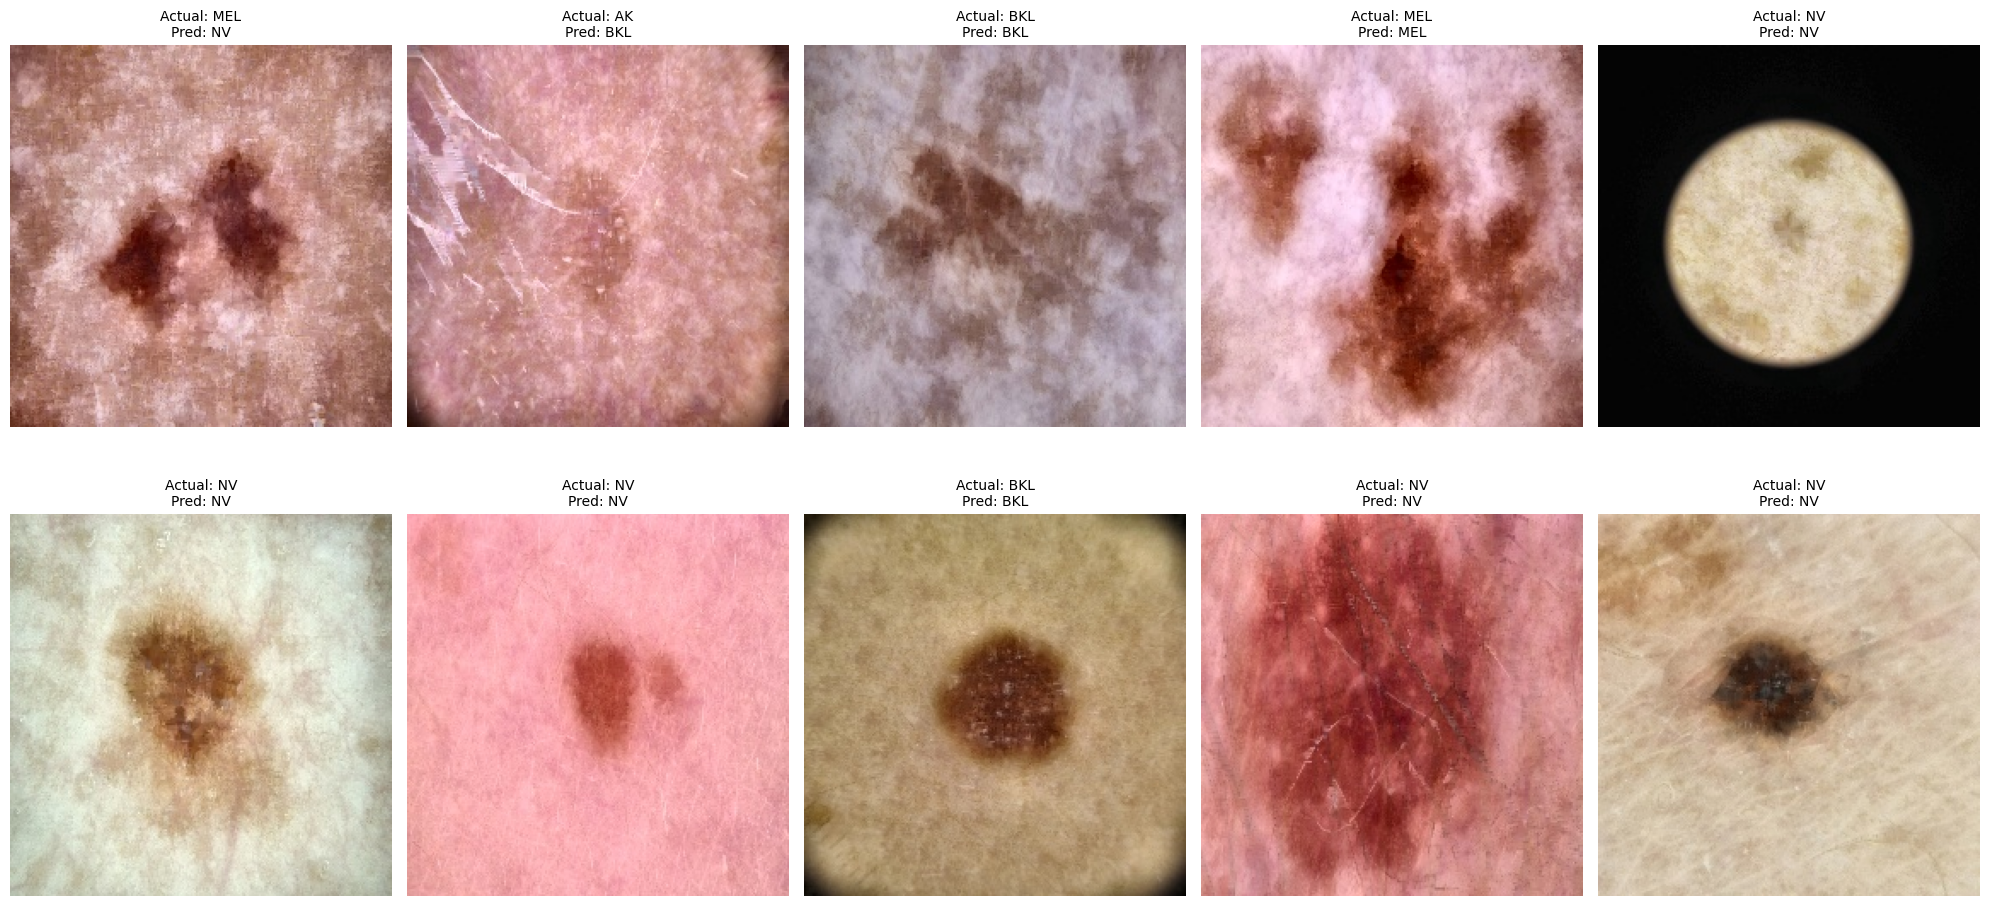

In [9]:
import random
import matplotlib.pyplot as plt

# Pick 10 random indices
random_indices = random.sample(range(len(val_generator.image_filenames)), 10)

plt.figure(figsize=(20, 10))

for i, idx in enumerate(random_indices):
    # Get image info
    image_name = val_generator.image_filenames[idx]
    true_label_index = val_generator.labels[idx]
    true_label_name = val_generator.class_names[true_label_index]
    image_path = os.path.join(val_image_dir, image_name)

    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_normalized = image_rgb / 255.0
    input_image = np.expand_dims(image_normalized, axis=0)

    # Predict
    pred_probs = model.predict(input_image)
    pred_class_index = np.argmax(pred_probs, axis=1)[0]
    pred_class_name = val_generator.class_names[pred_class_index]

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Actual: {true_label_name}\nPred: {pred_class_name}", fontsize=10)

plt.tight_layout()
plt.show()


Predicting: 100%|██████████| 3800/3800 [06:35<00:00,  9.60it/s]


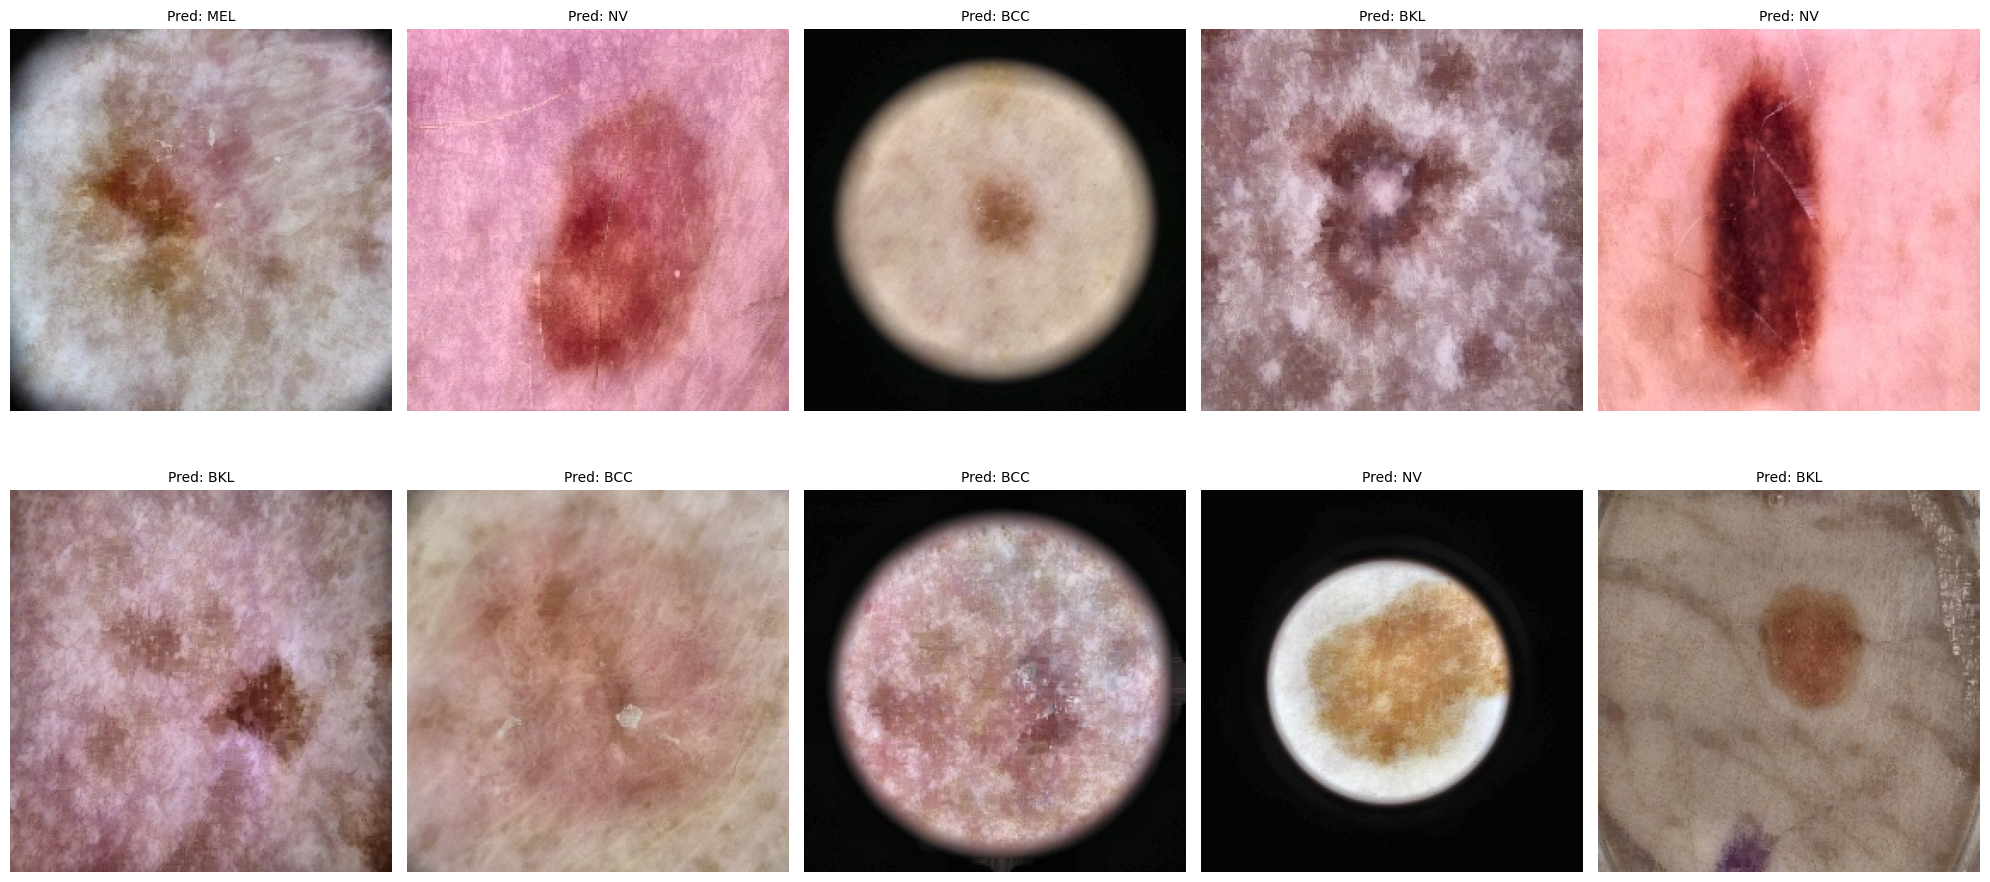

In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm

# === STEP 1: CONFIG ===
MODEL_PATH = '/kaggle/input/epoch26_2ndphase/tensorflow2/default/1/epoch_26 (1).h5'
TEST_IMAGE_DIR = '/kaggle/input/classification-skin/content/drive/MyDrive/skin_classification/Classification_Processed/Processed_test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 1

# Your label map used during training
label_map = {'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'SCC': 6, 'VASC': 7}
reverse_label_map = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

# === STEP 2: Load Model ===
model = load_model(MODEL_PATH)

# === STEP 3: Load Test Image Paths ===
test_image_paths = sorted([
    os.path.join(TEST_IMAGE_DIR, fname)
    for fname in os.listdir(TEST_IMAGE_DIR)
    if fname.lower().endswith(('.jpg', '.png', '.jpeg'))
])

# === STEP 4: Predict and Save ===
results = []

for image_path in tqdm(test_image_paths, desc="Predicting"):
    image_name = os.path.basename(image_path)
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMG_SIZE)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_norm = image_rgb / 255.0
    input_tensor = np.expand_dims(image_norm, axis=0)

    # Predict
    pred_probs = model.predict(input_tensor, verbose=0)
    pred_index = np.argmax(pred_probs, axis=1)[0]
    pred_label = reverse_label_map[pred_index]

    results.append({
        'image': image_name,
        'predicted_class': pred_label
    })

# # Save to CSV
# results_df = pd.DataFrame(results)
# results_df.to_csv('test_predictions.csv', index=False)
# print("✅ Predictions saved to test_predictions.csv")
import random

plt.figure(figsize=(20, 10))
random_indices = random.sample(range(len(test_image_paths)), 10)

for i, idx in enumerate(random_indices):
    img_path = test_image_paths[idx]
    image = cv2.imread(img_path)
    image = cv2.resize(image, IMG_SIZE)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_norm = image_rgb / 255.0
    input_tensor = np.expand_dims(image_norm, axis=0)

    # Predict
    pred = model.predict(input_tensor, verbose=0)
    pred_index = np.argmax(pred, axis=1)[0]
    pred_label = reverse_label_map[pred_index]

    # Show
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_rgb)
    plt.title(f"Pred: {pred_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
# === STEP 4: Predict and Save (with confidence) ===
results = []

for image_path in tqdm(test_image_paths, desc="Predicting"):
    image_name = os.path.basename(image_path)
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMG_SIZE)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_norm = image_rgb / 255.0
    input_tensor = np.expand_dims(image_norm, axis=0)

    # Predict
    pred_probs = model.predict(input_tensor, verbose=0)[0]  # shape: (num_classes,)
    pred_index = np.argmax(pred_probs)
    pred_label = reverse_label_map[pred_index]
    confidence = pred_probs[pred_index]

    results.append({
        'image': image_name,
        'predicted_class': pred_label,
        'confidence': round(float(confidence), 4)  # rounded to 4 decimals
    })

Predicting: 100%|██████████| 3800/3800 [06:15<00:00, 10.13it/s]


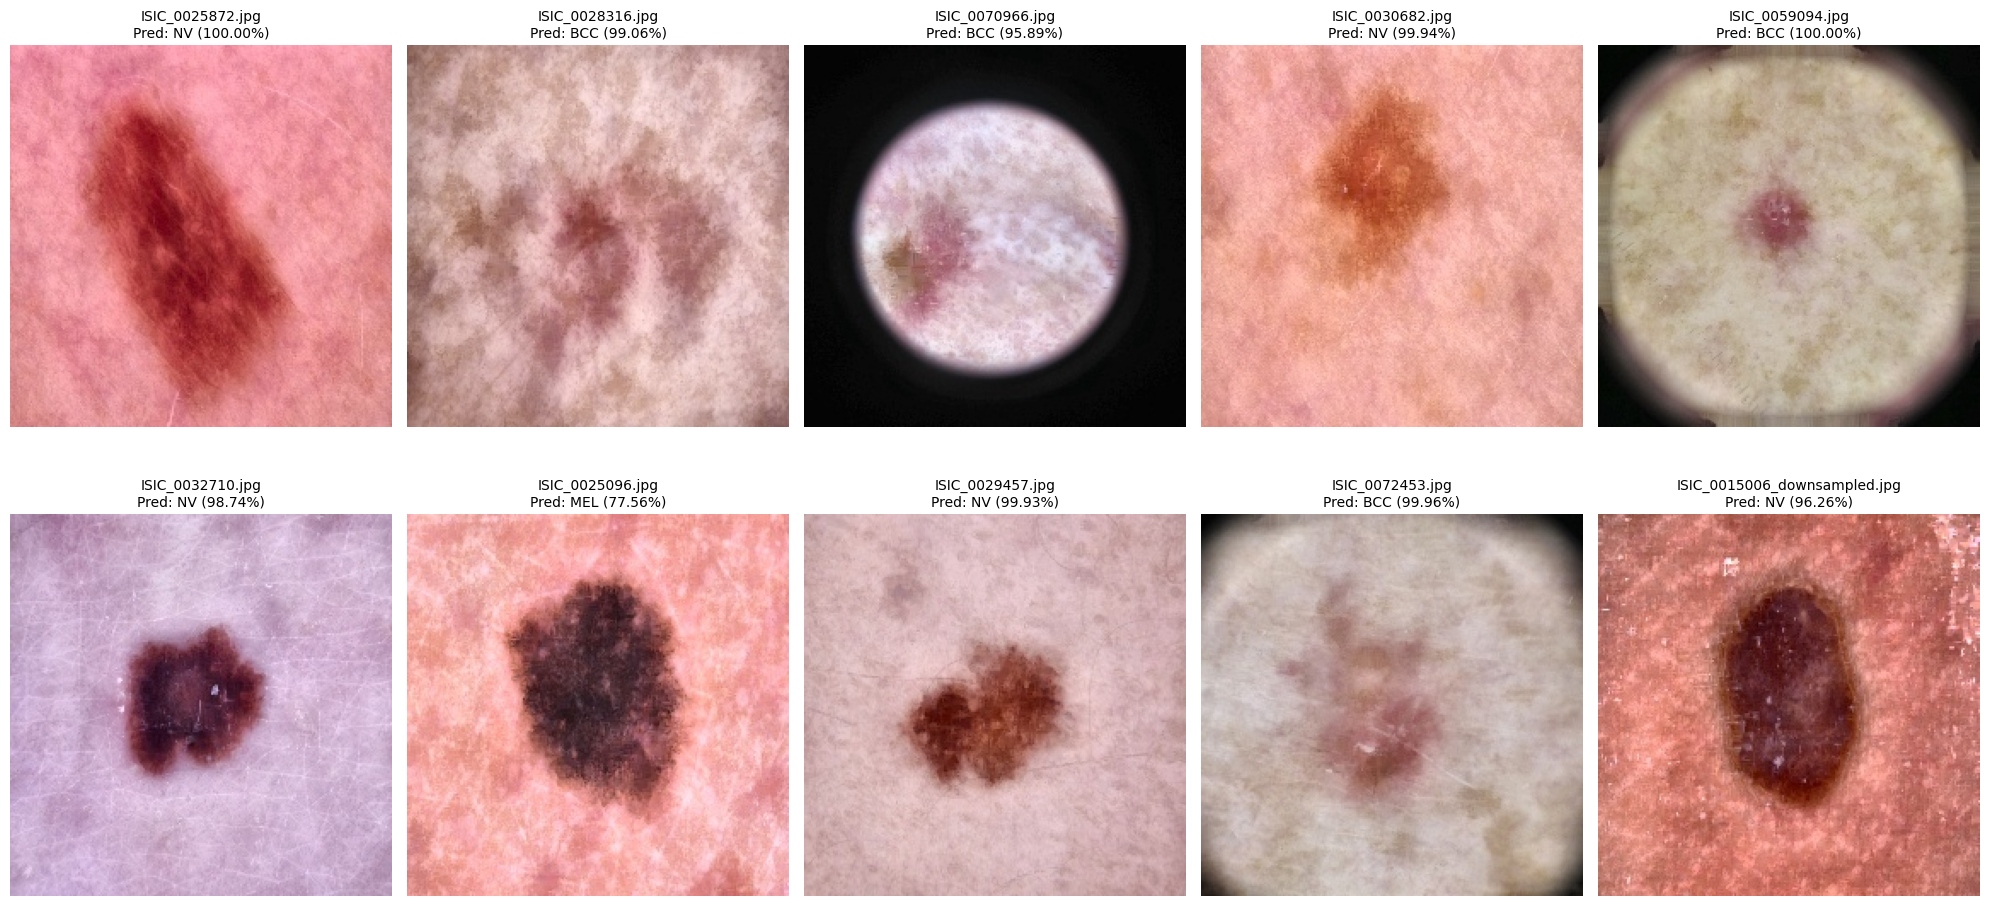

In [14]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm

# === CONFIGURATION ===
IMG_SIZE = (224, 224)
num_images_to_show = 10

# Replace these paths with your actual test folder and model path
test_image_dir = '/kaggle/input/classification-skin/content/drive/MyDrive/skin_classification/Classification_Processed/Processed_test'  # e.g. '/content/drive/MyDrive/skin_classification/Classification_Processed/Processed_test'
model_path = '/kaggle/input/epoch26_2ndphase/tensorflow2/default/1/epoch_26 (1).h5'    # your trained model path

# If you have a label mapping (index to class name)
reverse_label_map = {
    0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'
}

# === Load Model ===
model = load_model(model_path)

# === Get all test image paths ===
all_test_images = [os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir)
                   if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

# === Randomly select N images ===
selected_images = random.sample(all_test_images, num_images_to_show)

# === Plot Images ===
plt.figure(figsize=(20, 10))

for i, image_path in enumerate(selected_images):
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMG_SIZE)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_norm = image_rgb / 255.0
    input_tensor = np.expand_dims(image_norm, axis=0)

    # Predict
    pred_probs = model.predict(input_tensor, verbose=0)[0]
    pred_index = np.argmax(pred_probs)
    pred_label = reverse_label_map[pred_index]
    confidence = pred_probs[pred_index]

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"{os.path.basename(image_path)}\nPred: {pred_label} ({confidence:.2%})", fontsize=10)

plt.tight_layout()
plt.show()
